In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn
from torch.optim.lr_scheduler import StepLR

In [16]:
# Definindo a rede neural

class GravityNet(nn.Module):

    def __init__(self, neuronio, M, output=1, activation=None):

        """
        Atributos:
            neuronio: Define o número de neurônios em cada camada oculta.
            M: Número de camadas ocultas.
            output: Número de neurônios na camada de saída.
            activation: A função de ativação para as camadas ocultas.
        """
        super(GravityNet, self).__init__()
        self.neuronio = neuronio
        self.M = M
        self.output = output

        # Lista para armazenar as camadas lineares
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neuronio)])
        self.hidden_layers.extend([nn.Linear(neuronio, neuronio) for _ in range(M-1)])
        
        # Última camada linear
        self.output_layer = nn.Linear(neuronio, output)

        # Função de ativação
        self.activation = activation

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    
def soluçao_analitivca_OHM(x_0,omega_0,t):
    return x_0*tc.cos(omega_0*t)

tensor(0.9905)


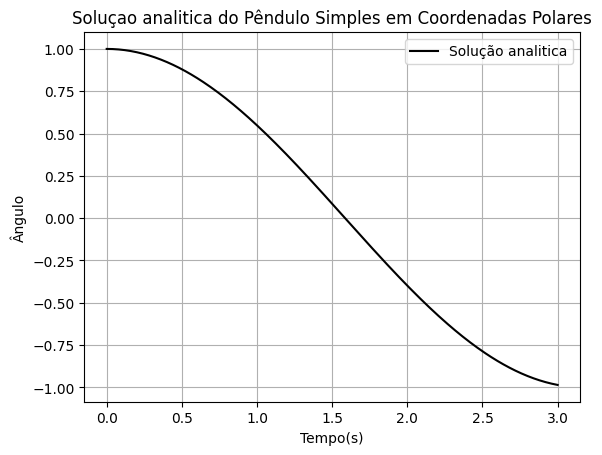

In [17]:
x_0 = 1 # Condiçao inicial 
t_i = 0       # Tempo inicial  
t_f = 3     # Tempo final 

comprimento_pendulo = tc.tensor(10) # Comprimento do pendulo em metros
Omega_0 = tc.sqrt(9.81/comprimento_pendulo) # frequencia de oscilação
print(Omega_0)

# Criando os dados de treino
t_train = tc.linspace( t_i, t_f, 300).reshape(-1,1) # Tempo. 
theta_train = soluçao_analitivca_OHM( x_0 = x_0, omega_0 = Omega_0 , t = t_train) # Solução analitivca do OHS.

plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(),"k-", label="Solução analitica")

# Adicionando rótulos e título
plt.ylabel("Ângulo")
plt.xlabel("Tempo(s)")
plt.title("Soluçao analitica do Pêndulo Simples em Coordenadas Polares")
plt.legend()
plt.grid(True)
plt.show()

Como objetivo q representar dados "experimentais", iremos tomar valores aleatorios dentro da soluçao analitica 

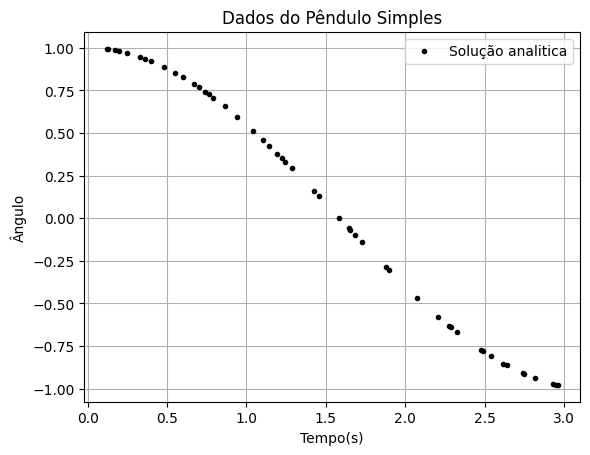

In [18]:
tc.manual_seed(42) # estamos fixando o valor do gerador de numeros aleatorio
indices = tc.multinomial(input=tc.ones(len(t_train)), num_samples=50, replacement=False) #len(x_train)//10
plt.plot(t_train[indices].detach().numpy(), theta_train[indices].detach().numpy(),"k.", label="Solução analitica")

# Adicionando rótulos e título
plt.ylabel("Ângulo")
plt.xlabel("Tempo(s)")
plt.title("Dados do Pêndulo Simples")
plt.legend()
plt.grid(True)
plt.show()


Nosso objetivo é aprender qual é a aceleração da gravidade. Para tanto, iremos considerar que sabemos o ângulo theta em cada instante de tempo, o comprimento do pêndulo e o ângulo inicial, como representado na figura acima.

Nossa rede neural irá representar um dos parâmetros da solução:

$$
\theta(t) = \theta_0cos(\omega* t) 
$$
onde $ \omega =  \sqrt{\frac{g}{l}}$ onde g é a gravidade e  l o comprimento do pendulo.  

Para nossa aplicação, vamos assumir que não sabemos qual o valor de 𝑔 , mas deixaremos a expressão em termos de 
$\omega$. Sabendo o valor de $\omega$ e $l$, podemos obter g através da expressão:

$$
g = w^2 \cdot l
$$


Note que é um objetivo bem simples, o intuito é apenas ilustrar ao leitor com podemos utilizar a rede neural para aprender um parametro físico.


In [19]:
# Definindo a rede neural 
net = GravityNet(neuronio=1,M=1,activation=nn.Tanh())

# Loss e otimizador
optimizer = tc.optim.Adam(net.parameters(), lr=0.001) # definindo o otimizador 

# Criando um scheduler para diminuir o learning rate a cada 'step_size' épocas
scheduler = StepLR(optimizer, step_size=10000, gamma=0.9)

In [20]:
# loss
LOSS = []

# Treinamento
for epoch in range(5000):
    omega = net(t_train)
    # Se observamos a variavel "gravidade" é um vetor, com tamanho igual a t_train
    # para utilizar como parametro ele deve ser apenas um numero
    # Portando iremos tomar a media desse vetor para usar como gravidade.
    w = tc.mean(omega)

    #theta_redeneural= x_0*tc.cos(tc.sqrt(g/comprimento_pendulo)*t_train)
    theta_NN = x_0*tc.cos(w*t_train)  
    loss1 = tc.mean((theta_train-theta_NN)**2)

    # podemos impor que, independentemente do input, o parametro deve ser igual
    loss2 = tc.mean(abs(omega-w))
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    LOSS.append(loss.item())

gravidade = net(t_train) # Rede neural
g = gravidade.mean().detach().numpy()
print("Valor da aceleração da gravidade",g**2*comprimento_pendulo)

Valor da aceleração da gravidade tensor(9.7540)


Note que esse valor não é exatamente o valor da gravidade, é um valor aproximado.
$$g \approx g'$$

E mesmo assim satifaz a curva teorica, utilizando o valor exato da gravidade.


In [21]:
# Nosso erro foi de 
print("Erro:", abs(g**2*comprimento_pendulo - 9.81))

Erro: tensor(0.0560)


Que para nosso problema, é um erro pequeno 

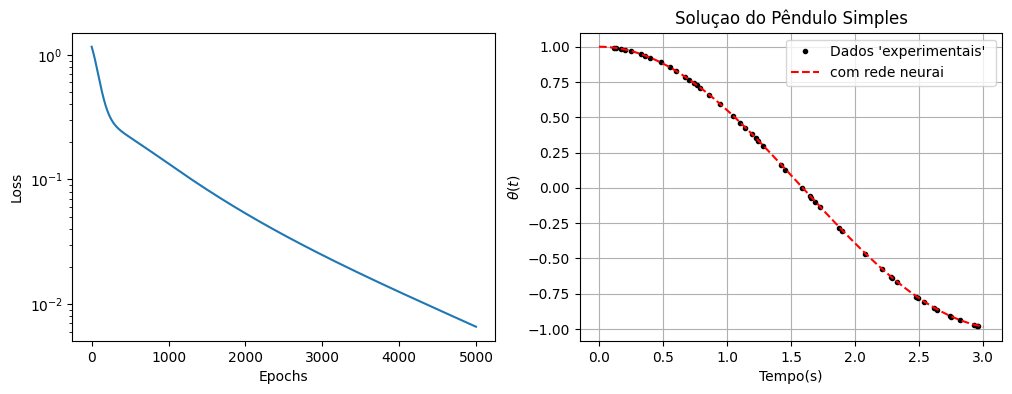

In [22]:

w = tc.mean(net(t_train))
theta_NN = x_0*tc.cos(w*t_train)

# Definindo o tamanho da figura (largura, altura) em polegadas
plt.figure(figsize=(12, 4))  # Aumente os valores conforme necessário

plt.subplot(1,2,1)
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.subplot(1,2,2)
plt.plot(t_train[indices].detach().numpy(),theta_train[indices].detach().numpy(),'k.',label="Dados 'experimentais' ")
plt.plot(t_train.detach().numpy(),theta_NN.detach().numpy(),'r--',label="com rede neurai")
# Adicionando rótulos e título
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Tempo(s)")
plt.title("Soluçao do Pêndulo Simples")
plt.legend()
plt.grid()
plt.show()

Podemos utilizar o resultado para prever a região fora do dominio de treinamento 

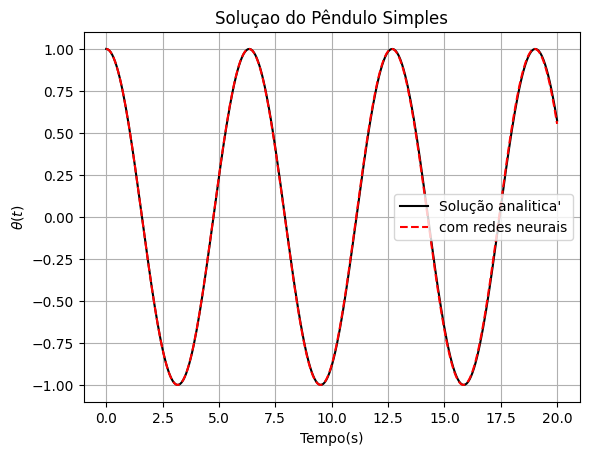

In [23]:
# Criando os dados de treino
t_train = tc.linspace( 0, 20, 300).reshape(-1,1) # Tempo. 
theta_train = soluçao_analitivca_OHM( x_0 = x_0, omega_0 = Omega_0 , t = t_train) # Solução analitivca do OHS.

w = tc.mean(net(t_train))
theta_NN = x_0*tc.cos(w*t_train)

plt.plot(t_train.detach().numpy(),theta_train.detach().numpy(),'k-',label="Solução analitica' ")
plt.plot(t_train.detach().numpy(),theta_NN.detach().numpy(),'r--',label="com redes neurais")
# Adicionando rótulos e título
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Tempo(s)")
plt.title("Soluçao do Pêndulo Simples")
plt.legend()
plt.grid()
plt.show()

# Exemplo extra

Estamos usando diferenciação automatica disponivel no pytorch para aprender  qual o valor de gravidade e da posição inicial.


Nesse caso estamos considerando que temos alguns dados experimentais que representam os valores de theta para cada instante de tempo.

Nosso objetivo é descobrir os "parãmetro experimentais" 
    $$
    \theta(t) = \theta_0cos(\sqrt{\frac{g}{l}}* t) 
    $$

Nesse caso é $\theta_0$ e $g$.

In [24]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Definindo a rede
class GravityNet(nn.Module):
    def __init__(self):
        super(GravityNet, self).__init__()
        self.g = nn.Parameter(tc.rand(1))
        self.x0 = nn.Parameter(tc.rand(1))


In [25]:
# Dados 
x_0 = 1
g_true  = 0.98
l_pendulo =  0.5

t_train = tc.linspace(0, 10, 100).unsqueeze(1)  # garantindo que t_train é uma coluna
theta_train = x_0 * tc.cos(tc.sqrt(tc.tensor(g_true) / l_pendulo) * t_train)

# Inicialização
net = GravityNet()
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

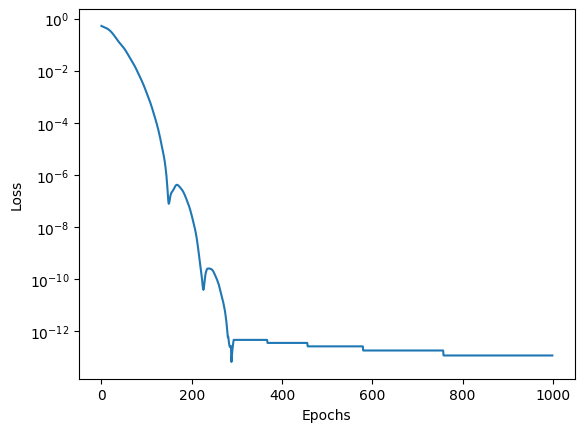

In [26]:
# Treinamento
LOSS = []
for epoch in range(1000):
    
    theta_NN = net.x0* tc.cos(tc.sqrt(net.g /l_pendulo) * t_train)

    loss = loss_fn(theta_train, theta_NN)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    LOSS.append(loss.item())
# Plot
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [27]:
print(" Valor de g: ",net.g.detach().numpy(),"\n Valor de x0:",net.x0.detach().numpy())

 Valor de g:  [0.97999996] 
 Valor de x0: [1.0000005]


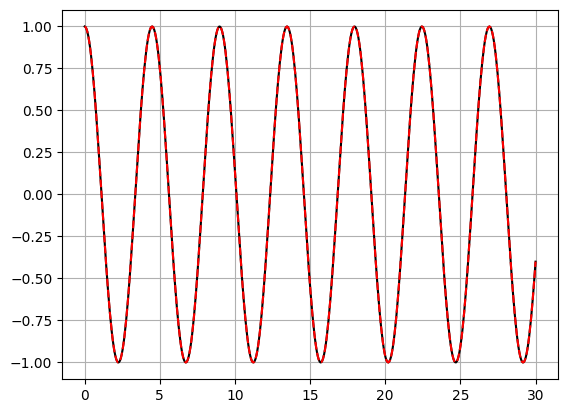

In [28]:
t_train = tc.linspace(0, 30, 500).unsqueeze(1)  # garantindo que t_train é uma coluna
theta_train = x_0 * tc.cos(tc.sqrt(tc.tensor(g_true) /l_pendulo) * t_train)
theta_NN    = net.x0* tc.cos(tc.sqrt(net.g/l_pendulo) * t_train)

plt.plot(t_train.detach().numpy(),theta_train.detach().numpy(),'k')
plt.plot(t_train.detach().numpy(),theta_NN.detach().numpy(),'r--')
plt.grid()
plt.show()